# Extracting from TMDB
Brittany Lassiter

## Imports

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, time
from tqdm.notebook import tqdm_notebook

In [2]:
# Create the folder for saving files (if it doesn't exist)
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'Data',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'IMDB Movie Dataset Info (2).docx',
 'movies-erd.png',
 'movies.2.mwb',
 'Movies.sql',
 'title-akas-us-only.xls',
 'title.basics (3).tsv.gz',
 'title.ratings (2).tsv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_YEAR.json',
 'tmdb_api_results_[2001, 2002].json',
 'Untitled.ipynb']

In [3]:
import json
with open("/Users/blass/.secret/tmdb_api.json", 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['API Key'])

In [4]:
import tmdbsimple as tmdb
tmdb.API_KEY =  login['API Key']

In [5]:
# Importing tmdbsimple and setting the API_KEY
import tmdbsimple as tmdb
tmdb.API_KEY =  login['API Key']

In [6]:
# Create the folder for saving files (if it doesn't exist)
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)

# Show the list of files included in the folder
sorted(os.listdir(FOLDER))

['.ipynb_checkpoints',
 'Data',
 'IMDB Movie Dataset Info (2).docx',
 'Movies.sql',
 'Untitled.ipynb',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'movies-erd.png',
 'movies.2.mwb',
 'title-akas-us-only.xls',
 'title.basics (3).tsv.gz',
 'title.ratings (2).tsv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_YEAR.json',
 'tmdb_api_results_[2001, 2002].json']

## Define Function

In [7]:
def get_movie_with_rating(movie_id):
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    
    # save the .info .releases dictionaries
    movie_info = movie.info()
    releases = movie.releases()
    
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            movie_info['certification'] = c['certification']
    return movie_info


def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

## Loading the Data

In [8]:
# Set the years to filter for
YEARS_TO_GET = [2001,2002]
# Create an empty list for saving errors
errors = []

In [9]:
import pandas as pd
basics = pd.read_csv('Data/title_basics_cleaned.csv.gz')
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama
...,...,...,...,...,...,...,...,...,...
86974,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
86975,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
86976,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
86977,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


In [11]:
# Start of Outer Loops
for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',position=0):
    #Defining the JSON file to Store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if the JSON file exists
    file_exists = os.path.isfile(JSON_FILE)

    # If it does not exist: create it
    if file_exists == False:
        print(f"Creating {JSON_FILE} for API results for year={YEAR}.")
        
    # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
                json.dump([{'imdb_id':0}],f)
    
    # If it exists, print a message
    else:
        print(f'The file {JSON_FILE} already exists.')

    # Filtering for movies from selected startYear
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst']
    movie_ids.head()

    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    previous_df

    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    movie_ids_to_get

    # Loop through movie_ids_to_get with a tqdm progress bar
    for movie_id in tqdm_notebook(movie_ids_to_get, f"Movies from {YEAR}"):
    
        # Attempt to retrieve then data for the movie id
        try:
            temp = get_movie_with_rating(movie_id)  #This uses your pre-ma    de function
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
    
        # If it fails,  make a dict with just the id and None for certification.
        except Exception as e:
            errors.append([movie_id, e])

    # Save the final results to a csv.gz file
    final_year_df = pd.read_json(JSON_FILE)
    
    csv_fname = f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz"
    final_year_df.to_csv(csv_fname, compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

The file Data/tmdb_api_results_2001.json already exists.


Movies from 2001:   0%|          | 0/219 [00:00<?, ?it/s]

Creating Data/tmdb_api_results_2002.json for API results for year=2002.


Movies from 2002:   0%|          | 0/1572 [00:00<?, ?it/s]

## Inner and Outer Loops 2001- 2002

# EDA PROCESS

In [12]:
# Load the data from your .csv.gz file into a new DataFrame.
df = pd.read_csv(csv_fname)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                1295 non-null   object 
 1   adult                  1294 non-null   float64
 2   backdrop_path          775 non-null    object 
 3   belongs_to_collection  120 non-null    object 
 4   budget                 1294 non-null   float64
 5   genres                 1294 non-null   object 
 6   homepage               106 non-null    object 
 7   id                     1294 non-null   float64
 8   original_language      1294 non-null   object 
 9   original_title         1294 non-null   object 
 10  overview               1262 non-null   object 
 11  popularity             1294 non-null   float64
 12  poster_path            1183 non-null   object 
 13  production_companies   1294 non-null   object 
 14  production_countries   1294 non-null   object 
 15  rele

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0096056,0.0,/95U3MUDXu4xSCmVLtWgargRipDi.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,109809.0,en,Crime and Punishment,...,0.0,126.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Crime and Punishment,0.0,5.300,12.0,NaN
2,tt0118926,0.0,/qR3Dk3ctnrrxkAI6I472RhamIbu.jpg,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,20689.0,en,The Dancer Upstairs,...,5227348.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"An honest man caught in a world of intrigue, p...",The Dancer Upstairs,0.0,6.200,51.0,R
3,tt0119980,0.0,NaN,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,563364.0,en,Random Shooting in LA,...,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Random Shooting in LA,0.0,0.000,0.0,NaN
4,tt0120679,0.0,/s04Ds4xbJU7DzeGVyamccH4LoxF.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.miramax.com/movie/frida,1360.0,en,Frida,...,56298474.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Prepare to be seduced.,Frida,0.0,7.424,1911.0,R


## How many movies had at least some valid financial information (values > 0 for budget OR revenue)?

In [14]:
filter_budget = df['budget'] >0
filter_budget.sum()

316

In [15]:
filter_revenue = df['revenue'] >0
filter_revenue.sum()

277

In [16]:
filter_financial = filter_revenue & filter_budget
filter_financial.sum()

215

In [17]:
# Remove any movies with 0's for budget AND revenue from the remaining visualizations.
df = df[filter_financial]
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
4,tt0120679,0.0,/s04Ds4xbJU7DzeGVyamccH4LoxF.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.miramax.com/movie/frida,1360.0,en,Frida,...,56298474.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Prepare to be seduced.,Frida,0.0,7.424,1911.0,R
5,tt0120804,0.0,/l5KvxFVOru3Qyf3dl2asNw5g1MD.jpg,"{'id': 17255, 'name': 'Resident Evil Collectio...",33000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",https://www.sonypictures.com/movies/residentevil,1576.0,en,Resident Evil,...,102984862.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A secret experiment. A deadly virus. A fatal m...,Resident Evil,0.0,6.611,5843.0,R
6,tt0120912,0.0,/o1l6OCqA3pYDZHIc5L1s7CEzCMv.jpg,"{'id': 86055, 'name': 'Men In Black Collection...",140000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.sonypictures.com/movies/meninblackii,608.0,en,Men in Black II,...,445135288.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Back in black.,Men in Black II,0.0,6.359,9293.0,PG-13
7,tt0121765,0.0,/abwxHfymXGAbbH3lo9PDEJEfvtW.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",120000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,1894.0,en,Star Wars: Episode II - Attack of the Clones,...,649398328.0,142.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A Jedi Shall Not Know Anger. Nor Hatred. Nor L...,Star Wars: Episode II - Attack of the Clones,0.0,6.550,12347.0,PG
8,tt0133240,0.0,/mVuH9hNGnxF9bbhlh1Tr9FuG3Uc.jpg,NaN,140000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",NaN,9016.0,en,Treasure Planet,...,109578115.0,95.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Find your place in the universe.,Treasure Planet,0.0,7.531,3834.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,tt0364385,0.0,/3ZDkl8rsoLe6g4FRV9alNH5sZOt.jpg,"{'id': 1972, 'name': 'Ju-on Collection', 'post...",3500000.0,"[{'id': 27, 'name': 'Horror'}]",NaN,11838.0,ja,呪怨,...,3657876.0,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,When a grudge from the dead passes to the livi...,Ju-on: The Grudge,0.0,6.684,708.0,R
1138,tt0365960,0.0,/ahXtNFVHtFxvjphZN8QlHRVsu9W.jpg,NaN,20000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,27090.0,en,Zero Day,...,8466.0,92.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,"In high school, you're told you can do anythin...",Zero Day,0.0,7.400,79.0,NaN
1225,tt0757920,0.0,/sOkmFOVcDmH2P4GU9Mvyc4ZBC3D.jpg,NaN,10000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,44078.0,fa,Dokhtar-e shirini-foroosh,...,10000.0,105.0,"[{'english_name': 'Persian', 'iso_639_1': 'fa'...",Released,NaN,The Pastry Girl,0.0,1.000,1.0,NaN
1241,tt1039983,0.0,/7B5IQdNNyNsSwBaW9zzCT9XmAcJ.jpg,NaN,500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,69419.0,ta,ரெட்,...,500000.0,157.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Red,0.0,5.100,7.0,NaN


In [18]:
print(f"There are {len(df)} movies with valid budget/revenue.")

There are 215 movies with valid budget/revenue.


## How many movies are there in each of the certification categories (G/PG/PG-13/R)?

R        79
PG-13    67
NaN      42
PG       18
G         6
NR        3
Name: certification, dtype: int64

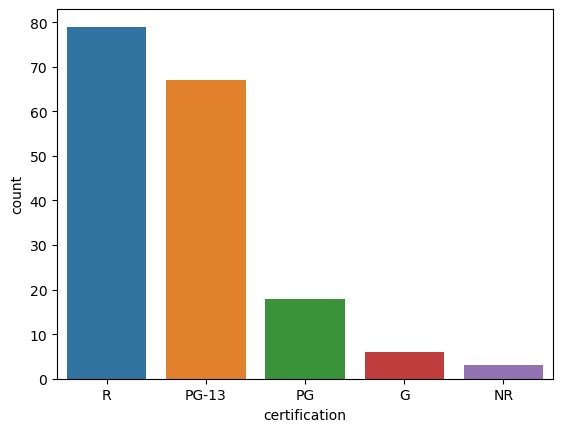

In [19]:
sns.countplot(data=df, x='certification');
df['certification'].value_counts(dropna=False)

## What is the average revenue per certification category?

certification
G       $ 108,695,069
NR        $ 2,393,180
PG      $ 220,426,659
PG-13   $ 114,070,214
R        $ 39,965,129
Name: revenue, dtype: float64

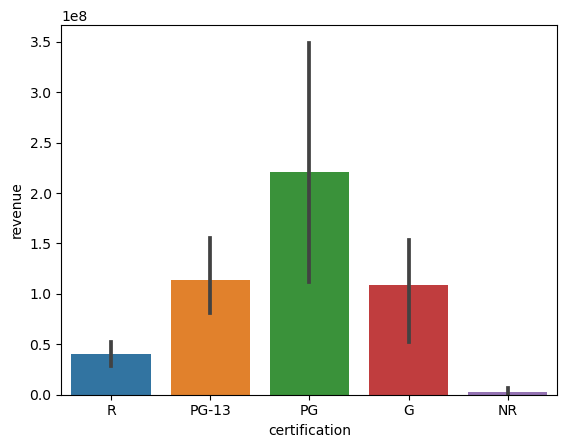

In [20]:
with pd.option_context('display.float_format',lambda x: f"$ {x:,.0f}"):
    display(df.groupby('certification')['revenue'].mean())

sns.barplot(data=df, x='certification', y='revenue');

## What is the average budget per certification category?

certification
G       $ 52,333,333
NR       $ 4,233,333
PG      $ 53,322,222
PG-13   $ 42,681,058
R       $ 26,070,457
Name: budget, dtype: float64

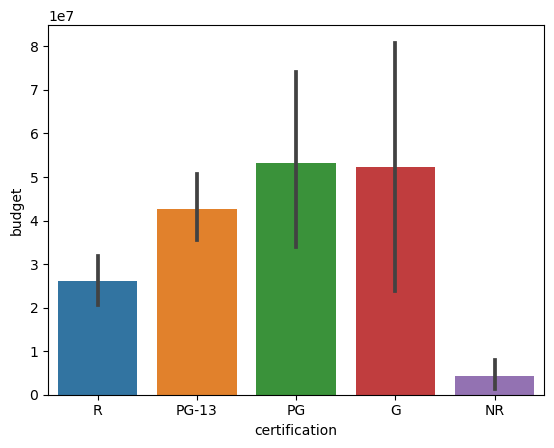

In [21]:
with pd.option_context('display.float_format',lambda x: f"$ {x:,.0f}"):
    display(df.groupby('certification')['budget'].mean())

sns.barplot(data=df, x='certification', y='budget');